In [ ]:
!pip install xarray netCDF4 pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.9 MB/s eta 0:00:00


In [ ]:
# run this first cell in Colab
!pip install xarray netCDF4 pandas pyarrow scikit-learn ctgan joblib matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.5 MB/s eta 0:00:00


In [1]:
import xarray as xr

def process_dataset(file_path, var_list, save_path=None):
    """
    Processes a NetCDF dataset:
    - Extracts top10 mean for all vars
    - Extracts min_profile if O2 present
    - Drops depth dimension
    - Saves reduced dataset if save_path is given
    """
    ds = xr.open_dataset(file_path)
    out_vars = {}

    for var in var_list:
        if var not in ds.data_vars:
            print(f"⚠️ {var} not in dataset {file_path}, skipping.")
            continue

        # Top 10 m mean
        top10 = ds[var].sel(depth=slice(0, 10)).mean(dim="depth")
        out_vars[f"{var}_top10_mean"] = top10

        # Special case: Oxygen → also compute min_profile
        if var == "o2":
            min_prof = ds[var].min(dim="depth")
            out_vars[f"{var}_min_profile"] = min_prof

    # Build reduced dataset
    new_ds = xr.Dataset(out_vars)

    # Save if requested
    if save_path:
        encoding = {k: {"zlib": True, "complevel": 4} for k in new_ds.data_vars}
        new_ds.to_netcdf(save_path, encoding=encoding)
        print(f"✅ Saved {save_path}")

    return new_ds


In [11]:
phyto_file = "cmems_mod_glo_bgc-pft_anfc_0.25deg_P1D-m_1758149257160.nc"   # chl
bio_file   = "cmems_mod_glo_bgc-bio_anfc_0.25deg_P1D-m_1758139995595.nc"   # o2, nppv
nut_file   = "cmems_mod_glo_bgc-nut_anfc_0.25deg_P1D-m_1758149705539.nc"   # no3, po4
carb_file  = "cmems_mod_glo_bgc-car_anfc_0.25deg_P1D-m_1758148870648.nc"   # ph, dissic
sst_file   = "cmems_mod_glo_phy_anfc_0.083deg-sst-anomaly_P1D-m_1758161150577.nc" # sst anomaly

ds_phyto = process_dataset(phyto_file, ["chl"])
ds_bio   = process_dataset(bio_file, ["o2", "nppv"])
ds_nut   = process_dataset(nut_file, ["no3", "po4"])
ds_carb  = process_dataset(carb_file, ["ph", "dissic"])
ds_sst   = xr.open_dataset(sst_file)  # already surface-only


In [13]:
# Regrid SST anomaly to match Bio grid (0.25°)
ds_sst_regrid = ds_sst.interp(
    latitude=ds_bio.latitude,
    longitude=ds_bio.longitude,
    method="nearest"
)

# Now merge
merged = xr.merge([ds_phyto, ds_bio, ds_nut, ds_carb, ds_sst_regrid])

merged.to_netcdf("merged_surface_top10.nc")

In [14]:
df = merged.to_dataframe().reset_index()
df.to_parquet("ml_ready_raw.parquet", index=False)
print("✅ Raw ML dataset saved:", df.shape)


✅ Raw ML dataset saved: (2880054, 12)


In [15]:
from sklearn.preprocessing import StandardScaler

# 1) Drop rows with NaN (or use fillna if you prefer interpolation)
df = df.dropna()

# 2) Features (exclude coords + label)
feature_cols = [c for c in df.columns if c not in ["time", "latitude", "longitude"]]
X = df[feature_cols].copy()

# 3) Scale features (important for ML except RandomForest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Features scaled. Shape:", X_scaled.shape)


✅ Features scaled. Shape: (2621795, 9)


In [16]:
import numpy as np

def label_impacts(row):
    if row["chl_top10_mean"] > 0.3:
        return "Bloom"
    if row.get("o2_min_profile", 999) < 60:
        return "Hypoxia"
    if row["nppv_top10_mean"] > 30 and (row["no3_top10_mean"] < 1 or row["po4_top10_mean"] < 0.1):
        return "NutrientStress"
    if row["ph_top10_mean"] < 7.9:
        return "Acidification"
    if row["sea_surface_temperature_anomaly"] > 1:
        return "BleachingRisk"
    return "Normal"

df["impact_class"] = df.apply(label_impacts, axis=1)
print(df["impact_class"].value_counts())


impact_class
Normal            1211923
Bloom              576245
Hypoxia            469371
BleachingRisk      363725
NutrientStress        531
Name: count, dtype: int64


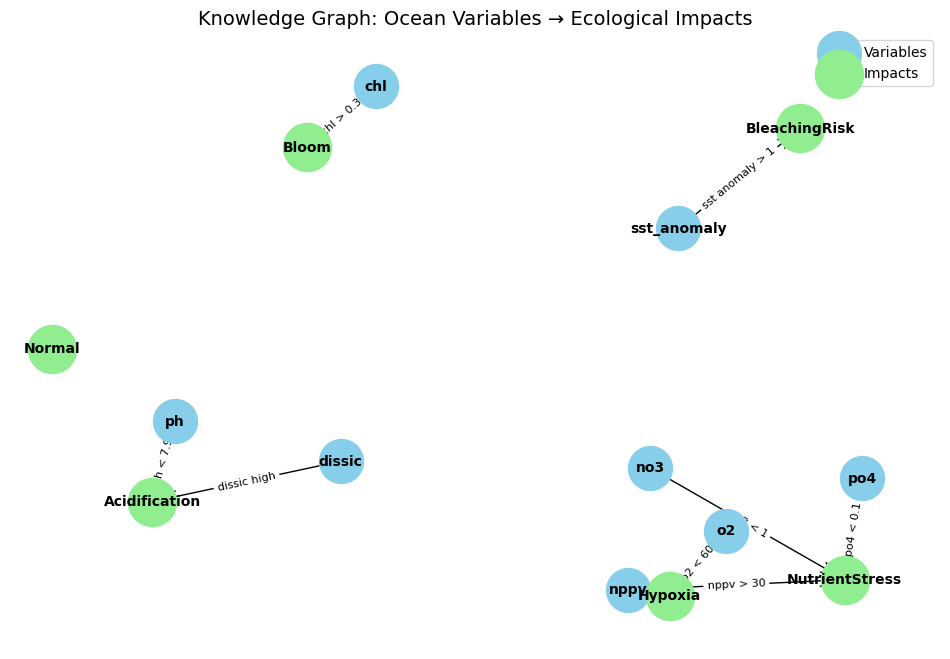

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph
G = nx.DiGraph()

# Variables
variables = ["chl", "o2", "nppv", "no3", "po4", "ph", "dissic", "sst_anomaly"]
G.add_nodes_from(variables, type="variable")

# Impacts
impacts = ["Bloom", "Hypoxia", "NutrientStress", "Acidification", "BleachingRisk", "Normal"]
G.add_nodes_from(impacts, type="impact")

# Edges (rules = knowledge)
rules = {
    ("chl", "Bloom"): "chl > 0.3",
    ("o2", "Hypoxia"): "o2 < 60",
    ("nppv", "NutrientStress"): "nppv > 30",
    ("no3", "NutrientStress"): "no3 < 1",
    ("po4", "NutrientStress"): "po4 < 0.1",
    ("ph", "Acidification"): "ph < 7.9",
    ("dissic", "Acidification"): "dissic high",
    ("sst_anomaly", "BleachingRisk"): "sst anomaly > 1"
}

for (src, tgt), rule in rules.items():
    G.add_edge(src, tgt, rule=rule)

# Draw graph
plt.figure(figsize=(12,8))

pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw variable nodes
var_nodes = [n for n, d in G.nodes(data=True) if d["type"]=="variable"]
nx.draw_networkx_nodes(G, pos, nodelist=var_nodes, node_color="skyblue", node_size=1000, label="Variables")

# Draw impact nodes
impact_nodes = [n for n, d in G.nodes(data=True) if d["type"]=="impact"]
nx.draw_networkx_nodes(G, pos, nodelist=impact_nodes, node_color="lightgreen", node_size=1200, label="Impacts")

# Draw edges
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Edge labels (rules)
edge_labels = nx.get_edge_attributes(G, "rule")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Knowledge Graph: Ocean Variables → Ecological Impacts", fontsize=14)
plt.legend(scatterpoints = 1)
plt.axis("off")
plt.show()


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

# ============================
# Step 12: Train ML Model
# ============================

# 1) Subsample to manageable size (100k rows)
df_sample = df.sample(n=100_000, random_state=42)

# 2) Drop non-numeric columns (skip if missing)
X = df_sample.drop(
    columns=["impact_class", "time", "region_quad", "NS_region", "EW_region"],
    errors="ignore"
)

# Target labels
y = df_sample["impact_class"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Define RandomForest (optimized for speed)
model = RandomForestClassifier(
    n_estimators=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# 5) Train
print("Training model on 100k samples...")
model.fit(X_train, y_train)

# 6) Predict & Evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 7) Save Model
joblib.dump(model, "ocean_impact_model.pkl")
print("\n✅ Model trained & saved as ocean_impact_model.pkl")


Training model on 100k samples...

Classification Report:

                precision    recall  f1-score   support

 BleachingRisk       1.00      1.00      1.00      2774
         Bloom       1.00      1.00      1.00      4382
       Hypoxia       1.00      1.00      1.00      3581
        Normal       1.00      1.00      1.00      9260
NutrientStress       1.00      0.33      0.50         3

      accuracy                           1.00     20000
     macro avg       1.00      0.87      0.90     20000
  weighted avg       1.00      1.00      1.00     20000


✅ Model trained & saved as ocean_impact_model.pkl
